In [144]:
import os
import datetime
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data

data = input_data.read_data_sets('./data/fashion')
sample = data.train.next_batch(110000)
dataset, dataLabel = sample[0], sample[1]

train_data, test_data, train_label, test_label = train_test_split(dataset, dataLabel, test_size=0.02)
train_data, test_data = train_data.reshape(-1, 28, 28), test_data.reshape(-1, 28, 28)

print(dataset.shape, dataLabel.shape)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

Extracting ./data/fashion/train-images-idx3-ubyte.gz
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz
(110000, 784) (110000,)
(107800, 28, 28) (107800,)
(2200, 28, 28) (2200,)


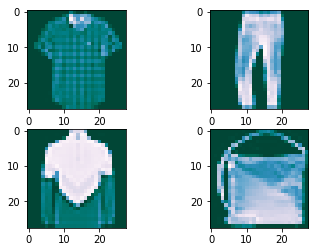

In [146]:
import random
import matplotlib.pyplot as plt

plt.subplot(221)
plt.imshow(test_data[10], cmap=plt.get_cmap('PuBuGn_r'))
plt.subplot(222)
plt.imshow(test_data[20], cmap=plt.get_cmap('PuBuGn_r'))
plt.subplot(223)
plt.imshow(test_data[30], cmap=plt.get_cmap('PuBuGn_r'))
plt.subplot(224)
plt.imshow(test_data[40], cmap=plt.get_cmap('PuBuGn_r'))
plt.show()
plt.close()

In [147]:
import numpy
import tensorflow as tf


class ConvolutionalNeuralNetwork(object):
    def __init__(self, filter_size=5, num_filters=6, num_classes=10):
        self.data = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name="data")
        self.label = tf.placeholder(tf.int32, shape=[None, 10], name="label")
        
        with tf.name_scope("one"):
            filter_shape = [filter_size, filter_size, 1, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
            self.conv1 = tf.nn.conv2d(input=self.data, filter=W, strides=[1, 1, 1, 1], padding="VALID")
            self.pool1 = tf.nn.avg_pool(value=self.conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')            
            
        with tf.name_scope("two"):
            filter_shape = [filter_size, filter_size, num_filters, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
            self.conv2 = tf.nn.conv2d(input=self.pool1, filter=W, strides=[1, 1, 1, 1], padding="VALID")
            self.pool2 = tf.nn.avg_pool(value=self.conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
            
        with tf.name_scope("full_connected_layer"):
            self.feature = tf.reshape(self.pool2, [-1, 160])
            W = tf.Variable(tf.truncated_normal(shape=[160, num_classes], stddev=0.1), name="full_connected_layer_W")
            b = tf.Variable(tf.truncated_normal(shape=[num_classes], stddev=0.1), name="full_connected_layer_b")
            self.logits = tf.nn.xw_plus_b(self.feature, W, b)
        
        with tf.name_scope("accuracy"):
            self.predict = tf.arg_max(self.logits, dimension=1)
            self.equal_tmp = tf.equal(self.predict, tf.arg_max(self.label, dimension=1))
            self.accuracy = tf.reduce_mean(tf.cast(self.equal_tmp, dtype=tf.float16))
            
        with tf.name_scope("loss"):
            self.losses = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.label, logits=self.logits)
            self.loss = tf.reduce_mean(self.losses)

In [150]:
def get_batch(epoches, batch_size):
    data = list(zip(train_data, train_label))
    for epoch in range(epoches):
        random.shuffle(data)
        for batch in range(0, len(data), batch_size):
            if batch + batch_size >= len(data):
                yield data[batch: len(data)]
            else:
                yield data[batch: (batch + batch_size)]

class ConvolutionalNeuralNetworkTrain(object):
    def __init__(self):
        # 定义CNN网络，对话窗口以及optimizer
        self.sess = tf.Session()
        self.CNN = ConvolutionalNeuralNetwork(filter_size=5, num_filters=10)

        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        self.optimizer = tf.train.AdamOptimizer(0.01).minimize(self.CNN.loss, global_step=self.global_step)
        self.sess.run(tf.global_variables_initializer())
        self.batches = get_batch(5, 300)

        # tensorboard
        tf.summary.scalar("loss", self.CNN.loss)
        tf.summary.scalar("accuracy", self.CNN.accuracy)
        self.merged_summary_op_train = tf.summary.merge_all()
        self.merged_summary_op_test = tf.summary.merge_all()
        self.summary_writer_train = tf.summary.FileWriter("./summary/train", graph=self.sess.graph)
        self.summary_writer_test = tf.summary.FileWriter("./summary/test", graph=self.sess.graph)


    def train_step(self, batch, label):
        feed_dict = {
            self.CNN.data: batch,
            self.CNN.label: label
        }
        _, summary, step, loss, accuracy = self.sess.run(
            fetches=[self.optimizer, self.merged_summary_op_train, self.global_step,
                     self.CNN.loss, self.CNN.accuracy],
            feed_dict=feed_dict)
        self.summary_writer_train.add_summary(summary, step)

        time_str = datetime.datetime.now().isoformat()
        print("{}: step {}, loss {}, accuracy {}".format(time_str, step, loss, accuracy))

    def dev_step(self, batch, label):
        feed_dict = {
            self.CNN.data: batch,
            self.CNN.label: label
        }
        summary, step, loss, accuracy = self.sess.run(
            fetches=[self.merged_summary_op_test, self.global_step, self.CNN.loss, self.CNN.accuracy],
            feed_dict=feed_dict)
        self.summary_writer_test.add_summary(summary, step)
        time_str = datetime.datetime.now().isoformat()
        print("{}: step {}, loss {:g}, accuracy {}".format(time_str, step, loss, accuracy))

    def main(self):
        def one_hot_encoder(ipt):
            zeros_ipt = np.zeros(shape=[len(ipt), 10], dtype=int)
            zeros_ipt[range(len(ipt)), np.array(ipt)] = 1
            return zeros_ipt
            
        for data in self.batches:
            x_train, y_train = zip(*data)
            x_train = np.expand_dims(np.array(x_train, dtype=float), -1)
            
            y_train = one_hot_encoder(y_train)
            self.train_step(x_train, y_train)
            
            current_step = tf.train.global_step(self.sess, self.global_step)
            if current_step % 20 == 0:
                print("\nEvaluation:")
                self.dev_step(np.expand_dims(np.array(test_data, dtype=float), -1), one_hot_encoder(test_label))
                print("\n")

In [151]:
tf.reset_default_graph()
model_train = ConvolutionalNeuralNetworkTrain()
aaa = model_train.main()

2019-04-10T00:49:57.762512: step 1, loss 2.346548557281494, accuracy 0.1400146484375
2019-04-10T00:49:57.810258: step 2, loss 2.235687017440796, accuracy 0.0999755859375
2019-04-10T00:49:57.856632: step 3, loss 2.105565071105957, accuracy 0.28662109375
2019-04-10T00:49:57.902892: step 4, loss 1.895173192024231, accuracy 0.42333984375
2019-04-10T00:49:57.949899: step 5, loss 1.661730408668518, accuracy 0.416748046875
2019-04-10T00:49:58.000373: step 6, loss 1.4527477025985718, accuracy 0.56689453125
2019-04-10T00:49:58.051097: step 7, loss 1.3320865631103516, accuracy 0.449951171875
2019-04-10T00:49:58.097726: step 8, loss 1.3091408014297485, accuracy 0.54345703125
2019-04-10T00:49:58.143625: step 9, loss 1.3012017011642456, accuracy 0.4599609375
2019-04-10T00:49:58.189817: step 10, loss 1.110469937324524, accuracy 0.646484375
2019-04-10T00:49:58.244024: step 11, loss 1.237715244293213, accuracy 0.56005859375
2019-04-10T00:49:58.294754: step 12, loss 1.0434966087341309, accuracy 0.57324